# Titanic

Competencia de Kaggle para poder predecir si un pasajero falleció 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

In [2]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


Se puede observar que este dataset tiene una buena cantidad de valores faltantes. Voy a ver especificamente que porporción corresponde a cada feature que no está completo. 

In [6]:
cant_filas = train.shape[0]
cant_columnas = train.shape[1]

def faltantes(dataf):
    for col in train.columns:

        vacios = np.sum(train[col].isnull())

        porcentaje = np.round((vacios/cant_filas)*100, decimals=2) 

        if vacios !=0:

            print('{} - {} - {} % '.format(col, vacios, porcentaje))

faltantes(train)

Age - 177 - 19.87 % 
Cabin - 687 - 77.1 % 
Embarked - 2 - 0.22 % 


## EDA

En esta sección se analizaran cada uno de los features presentes en el dataset y la capacidad predictora de los mismos. 

### Pclass

Se puede observar que hay una mayor probabilidad de sobrevivir, superior al 60% si el pasajero estaba presenten en la primera clase del barco. Por el contrario la probabilidad de supervivencia cae por denajo del 30% si el pasajero era de tercera clase.

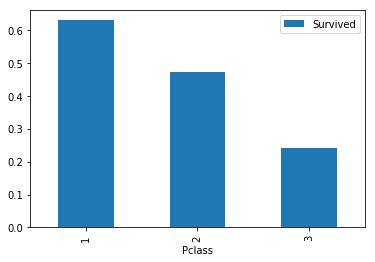

In [7]:
pd.pivot_table(train, index='Pclass', values='Survived').plot(kind = 'bar')

### Sex

En cuanto al sexo se ve claramente la mayor tasa de supervivencia en el caso de las mujeres (más del 70%) en comparación con los hombres que no llega al 20%.

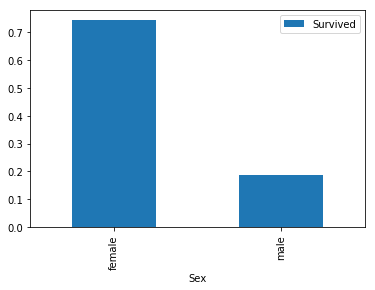

In [8]:
pd.pivot_table(train, index='Sex', values='Survived').plot(kind = 'bar')

### SibSp

Esta variable indica la cantidad de hermanos o esposa/marido para cada instancia del dataset. Como se puede observar la tasa de superviviencia es mayor en los casos donde hay pocos hermanos o parejas, parece indicar que a menor grupo fliar, mayor la tasa de superviviencia. 

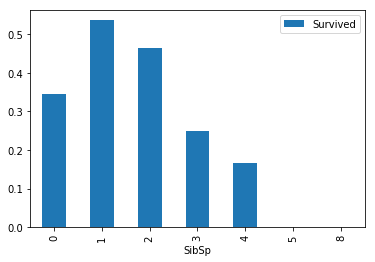

In [9]:
pd.pivot_table(train, index='SibSp', values='Survived').plot(kind = 'bar')

### Parch

Esta variable muestra la cantidad de hijos o padres que se registran para cada instancia. Al contrario de SibSp no es tan clara la supremacia de supervivencia ante familias chicas. 

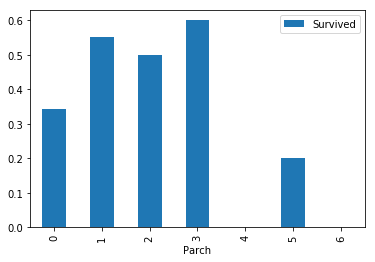

In [10]:
pd.pivot_table(train, index='Parch', values='Survived').plot(kind = 'bar')

### SibSp and Parch

Combinando las variables que indican la cantidad de hermanos/parejas y cantidad de hijos/padres podemos crear una nueva variable que indique el tamaño de la familia. Se corrobora que familias más grandes muestran tasas de supervivencia menores, incluso las que superan los 8 miembros, ninguno sobrevivió. 

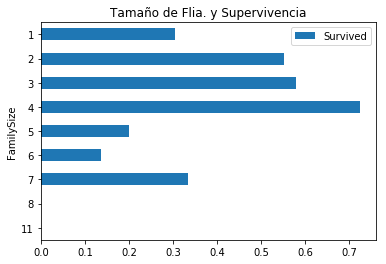

In [11]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

pd.pivot_table(train, index='FamilySize', values='Survived').sort_values(by = 'FamilySize', ascending = False).plot(kind = 'barh', title = 'Tamaño de Flia. y Supervivencia')

Creo otra variable, binaria esta vez, que me indique por cada instancia si el pasajero se encuentra solo o acompañado en el barco. Una vez más se verifica que pasajeros que se encuentran solos tienen una mayor tasa de supervivencia vs los que tienen algún familiar. 

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


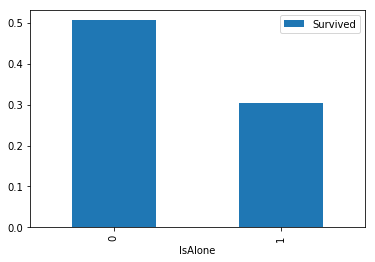

In [12]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())
pd.pivot_table(train, index='IsAlone', values='Survived').plot(kind = 'bar')

### Embarked

Puerto donde embarcaron: C = Cherbourg, Q = Queenstown, S = Southampton.

A priori no hay razones para pensar que la supervivencia de un pasajer este condicionada al puerto donde embarco, salvo que este relacionada con otra variable que si tenga esa correlación, por ejemplo, si la mayoría de los pasajeros de tercera clase embarcaron en un puerto en particular, y la tasa de supervivencia de estos es baja, entonces podríamos encontrar la asociación. Este tipo de causalidades puede llevar a regresiones espureas.

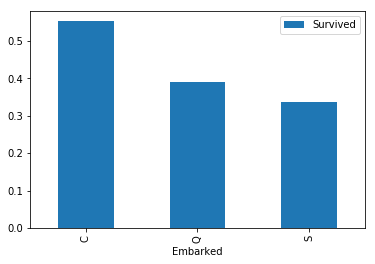

In [13]:
pd.pivot_table(train, index='Embarked', values='Survived').plot(kind = 'bar')

Se observa que en cada categoria de Ebarked la tasa de supervivencia mantiene la dinámica antes vista en Pclass (salvo para las que ebarcaron en Q, donde los de segunda clase tienen mayor tasa de supervivencia)

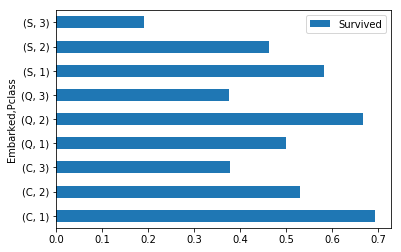

In [14]:
pd.pivot_table(train, index=['Embarked', 'Pclass'], values='Survived').plot(kind = 'barh')

### Fare

Esta variable tiene una gran cantidad de missing values como se pudo observar al principio. Se puede categorizar e imputar los valores faltantes con la media. A priori la intuición indica que se debería observar una relación como la indicada en Embarked, donde correlación con la supervivencia viene dada por la relación con otra variable, en este caso, Pclas. Para corroborarlo voy a testear si hay algún tipo de relación

Como era de esperar el Fare promedio es más alto en el caso de primera clase y cae rapidamente hasta llegar al minimo en tercera clase. 

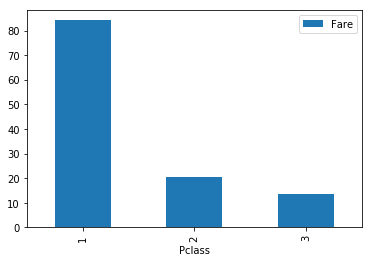

In [15]:
pd.pivot_table(train, index='Pclass', values='Fare').plot(kind = 'bar')

### Age

Existen unos cuantos valores vacios para esta variable y como a priori parece ser representativa de si un pasajero sobrevivió tengo que pensar alguna estrategia para imputarla

In [16]:
train['Age'][train['Age'].isna()].size

177

In [17]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

De la distribución (de los valores que no son vacios) se observa que la misma tiene un sesgo hacia la izquierda. La mejor medida para imputar sería la mediana.

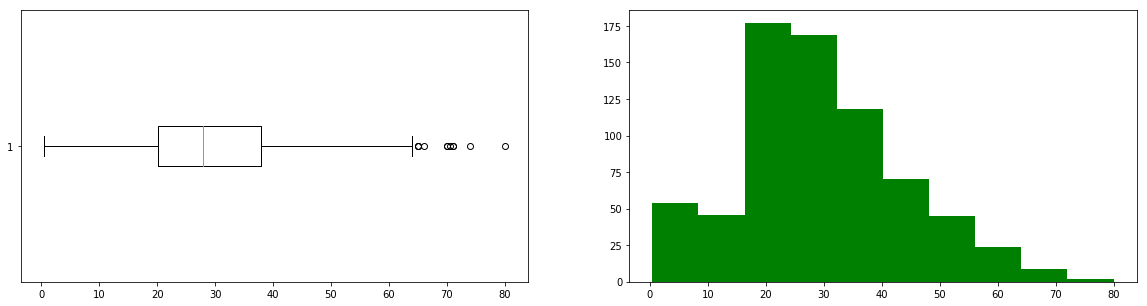

In [18]:
plt.figure(figsize=(20,5))

# Forma de la grilla y posición del subplot
plt.subplot(1,2,1)
plt.boxplot(train['Age'][train['Age'].notnull()], vert=False)

# Otro subplot
plt.subplot(1,2,2)
plt.hist(train['Age'][train['Age'].notnull()], color='green')

# Mostramos el gráfico
plt.show()

In [19]:
age_median = train['Age'][train['Age'].notnull()].median()
train['Age'].fillna(value = age_median, inplace = True)

### Title

Esta variable puede ayudar a entender tanto la edad del pasajero como el sexo del mismo, lo cual puede proveer de buena capacidad predictiva

In [122]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [132]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

In [125]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'IsAlone',
       'Title'],
      dtype='object')

In [21]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


Se puede observar que la probabilidad de supervivencia es más alta en el caso de las mujeres (Miss y Mrs), seguido por Master (según wikipedia:  "a way of addressing politely a boy ... too young to be called 'Mister'". Por último quedan los hombres.

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


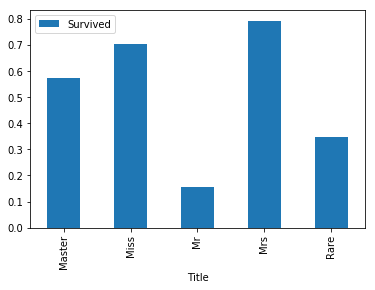

In [23]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())
pd.pivot_table(train, index='Title', values='Survived').plot(kind = 'bar')

## Feature Engineering

Transformo las variables categoricas en valores númericos que puedan ser interpretados por el modelo.

In [24]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'IsAlone',
       'Title'],
      dtype='object')

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
FamilySize     891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null object
dtypes: float64(2), int64(7), object(6)
memory usage: 83.6+ KB


A partir del EDA realizado me voy a quedar con los siguientes features para realizar el modelo:

- Pclass
- Sex
- Age
- Family Size
- IsAlone  
- Title          

In [26]:
df = train[['Survived', 'Pclass', 'Sex', 'Age', 'FamilySize', 'IsAlone',
       'Title']] 

In [29]:
df.head()

,Survived,Pclass,Sex,Age,FamilySize,IsAlone,Title
0,0,3,male,22.0,2,0,Mr
1,1,1,female,38.0,2,0,Mrs
2,1,3,female,26.0,1,1,Miss
3,1,1,female,35.0,2,0,Mrs
4,0,3,male,35.0,1,1,Mr


In [28]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()

In [43]:
lab_enc.fit(df['Sex'])
df['Sex'] = lab_enc.transform(df['Sex'])

C:\Users\cjy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
lab_enc.fit(df['Title'])
df['Title'] = lab_enc.transform(df['Title'])

C:\Users\cjy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
df.head()

,Survived,Pclass,Sex,Age,FamilySize,IsAlone,Title
0,0,3,1,22.0,2,0,2
1,1,1,0,38.0,2,0,3
2,1,3,0,26.0,1,1,1
3,1,1,0,35.0,2,0,3
4,0,3,1,35.0,1,1,2


## Preprocessing

Separo la matriz de features y el vector de targets

In [47]:
X = df[['Pclass', 'Sex', 'Age', 'FamilySize', 'IsAlone', 'Title']]
y = df[['Survived']]

Hago el split entre train y test para luego poder evaluar la capacidad de generalización del modelo

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

Armo la estrategia de cross validation, es necesario que esta sea igual para todos los modelos que voy a testear para que los resultados sean comparables

In [51]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

## Selección de modelos

Voy a realizar una primer prueba con los modelos: RandomForestClassifier(), ExtraTreesClassifier() y BaggingClassifier() y luego con dos de boosting (AdaBoost y GradientBoosting).

### RandomForestClassifier()

Este método implementa y ejectua un RandomForest para resolver un problema de clasificación. Algunos de los parámetros más importantes son los siguientes:

* `n_estimators`: el número de iteraciones (o sea, de `base_estimators`) para entrenar
* `criterion`: define el criterio de impureza para evaluar la calidad de las particiones (por defecto, es `gini`) 
* `max_features`: la cantidad de features que extraerá para entrenar cada `base_estimator`. Por default es igual a `sqrt(X.shape[1])`
* `bootstrap` y `bootstrap_features`: controla si tanto los n_samples como las features son extraidos con reposición.
* `max_depth`: la pronfundidad máxima del árbol
* `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
* `min_samples_split`: el número mínimo de n_samples para realizar un split.

y varios otros que pueden llegar a ser importantes al momento de realizar el tunning. En general, los más importantes suelen ser: `n_estimators`, `max_features`, `max_depth` y `min_samples_leaf`.


### ExtraTreesClassifier()

Con este método se puede estimar un conjunto de conjuntos de árboles de decisión randomizados. Toma los mismos parámetros que `RandomForestClassifier()`.


### BaggingClassifier()

Este método es muy interesante porque, a diferencia de los anteriores, es un "meta estimador", está situado en nivel de abstracción mayor. Es decir, que permite implementar el algoritmo de bagging (para clasificación) con casi cualquier estimador de Scikit-Learn. Toma como parámetros análogos a los dos métodos anteriores (con diferentes valores por defecto en algunos casos). Los únicos "nuevos" son: 

* `base_estimator`: el estimador sobre el cual queremos correr el bagging (regresiones, árboles, etc...)
* `max_samples`: la cantidad de n_samples que muestrea en cada iteración. Por default es igual a `sqrt(X.shape[0])`


Para comparar los diferentes algoritmos armamos la siguiente función. Toma como input un estimador y un string con el nombre que le quieran poner, y ejecuta un `cross_val_score`

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

# Evaluo los distintos modelos con la misma estrategia de CV y obtengo las métricas para comparar los resultados
def evaluar_rendimiento(modelo, nombre, X_train, y_train, cv):
    s = cross_val_score(modelo, X_train, y_train, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

Ahora instancio los modelos y evaluo todos los metodos

In [55]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=1)
bdt = BaggingClassifier(dt, random_state=1)
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
et = ExtraTreesClassifier(class_weight='balanced', random_state=1)

evaluar_rendimiento(dt,  "Árbol de decisión", X_train, y_train, cv)
evaluar_rendimiento(bdt, "Bagging AD", X_train, y_train, cv)
evaluar_rendimiento(rf,  "Random Forest", X_train, y_train, cv)
evaluar_rendimiento(et,  "Extra Trees", X_train, y_train, cv)

Rendimiento de Árbol de decisión:	0.744 ± 0.011
Rendimiento de Bagging AD:	0.775 ± 0.007
Rendimiento de Random Forest:	0.789 ± 0.006
Rendimiento de Extra Trees:	0.77 ± 0.008


Los resultados no son del todo malos pero pueden mejorarse, màs que nada a la vista de los resultados que se obtienen en otras competencias de Kaggle. 

Voy a realizar un tuneo de hiperparametros del Random Forest para ver si puedo conseguir unos puntos màs.

In [58]:
from sklearn.model_selection import GridSearchCV
param_trees = {'n_estimators': [50, 100, 200], 
               'max_features': [2, 3, 4, 5, 6], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

In [59]:
# Instancio el Grid
grid_search_rf = GridSearchCV(rf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=3)

# Fiteo el grid
grid_search_rf.fit(X_train, y_train)

# Obtengo los mejores hiperparametros del RF
grid_search_rf.best_estimator_

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   12.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   45.7s
[Parallel(n_jobs=3)]: Done 1125 out of 1125 | elapsed:  1.1min finished
C:\Users\cjy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

El rendimiento del modelo se ve incrementado luego de realizar el GridSearch

In [60]:
evaluar_rendimiento(grid_search_rf,  "Random Forest GS", X_train, y_train, cv)

Rendimiento de Random Forest GS:	0.808 ± 0.02


## Boosting

Voy a probar ahora con dos algoritmos de boosting a ver si puedo obtener mejores resultados que con los clasificadores antes utilizados

### `AdaBoostClassifier()`

La idea central de AdaBoost es construir un ensamble de week learners y, en cada iteración ir incrementando el peso de los casos mal clasificados. La implementación den Scikit-Learn toma los siguientes parámetros:

* `base_estimator`: análogo al caso de `BaggingClassifier()`, el estimador sobre el cual se va a construir el ensamble. Por efecto, son árboles de decisión.
* `n_estimators`: el máximo de iteraciones
* `learning_rate`: el peso que va a tener la predicción de cada árbol en el ensamble final


### `GradientBoostingClassifier()`

Se trata de una generalización del algoritmo general de Boosting para cualquier tipo de función de pérdida diferenciable. En cada etapa, se fitea un árbol de decisión pero se realiza sobre los residuos del árbol anterior. Es decir, se busca corregir las estimaciones entrenando nuevos clasificadores sobre los "residuos" (la diferencia entre el valor observado y el valor predico ($y - \hat{y}$)

Los argumentos que toma como input son ya conocidos:

* `learning_rate`: el peso que va a tener la predicción de cada árbol en el ensamble final

* `n_estimators`: el máximo de iteraciones
* `criterion`: define el criterio de impureza para evaluar la calidad de las particiones
* `max_features`: la cantidad de features que extraerá para entrenar cada `base_estimator`. Por default es igual a `sqrt(X.shape[1])`
* `bootstrap` y `bootstrap_features`: controla si tanto los n_samples como las features son extraidos con reposición.
* `max_depth`: la pronfundidad máxima del árbol
* `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
* `min_samples_split`: el número mínimo de n_samples para realizar un split.


In [61]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1), n_estimators=100)
gb = GradientBoostingClassifier()
evaluar_rendimiento(ab, "AdaBoostClassifier",  X_train, y_train, cv)
evaluar_rendimiento(gb, "GradientBoostingClassifier", X_train, y_train, cv)

Rendimiento de AdaBoostClassifier:	0.801 ± 0.011
Rendimiento de GradientBoostingClassifier:	0.805 ± 0.008


Con los hiperarametros que vienen por defecto ya obtengo un resultado similar al del Random Forest con tuneo, voy a realizar entonces un GridSearch para estos nuevos metodos a ver si puedo mejorar aún más los resultados obtenidos.

Arranco con el AdaBoost

In [62]:
params_ab = {"n_estimators": [100, 500],
          "learning_rate":[0.01, 0.1, 1.0],
        "base_estimator__max_depth": [1, 2, 3]}

grid_ab = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
                       param_grid=params_ab, cv=cv, verbose=1, n_jobs=3)

In [63]:
# Fiteo el Grid
grid_ab.fit(X_train, y_train)

# Obtengo el mejor set de hiperparametros
grid_ab.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.7s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:   10.6s finished
C:\Users\cjy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=500, random_state=None)

Es levemente mejor que el Random Forest

In [64]:
evaluar_rendimiento(grid_ab,  "AdaBoostClassifier + GS", X_train, y_train, cv)

Rendimiento de AdaBoostClassifier + GS:	0.809 ± 0.014


Pruebo ahora tuneando el GB

In [65]:
params_gb = {'n_estimators':[100, 500] , 
             'learning_rate':[0.001, 0.001, 0.1, 1.0],
            'max_depth' : [1, 2, 3, 4]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=3)

In [66]:
# Fiteo el metodo
grid_gb.fit(X_train, y_train)

# Obtengo el mejor set de hiperparametros
grid_gb.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:    7.4s finished
C:\Users\cjy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Mejora todos los modelos utilizados hasta ahora

In [67]:
evaluar_rendimiento(grid_gb, "GradientBoostingClassifier + GS", X_train, y_train, cv)

Rendimiento de GradientBoostingClassifier + GS:	0.817 ± 0.014


## Genearalización

In [70]:
from sklearn.metrics import roc_auc_score

In [107]:
y_predicted_gb = grid_gb.predict(X_test)

In [108]:
roc_auc_score(y_test,y_predicted_gb)

0.8633204633204633

In [105]:
y_predicted_ab = grid_ab.predict(X_test)

In [106]:
roc_auc_score(y_test,y_predicted_ab)

0.8537966537966539

In [102]:
y_predicted_rf = grid_search_rf.predict(X_test)

In [104]:
roc_auc_score(y_test,y_predicted_rf)

0.8565637065637065

Los resultados de las areas debajo de la curva ROC son consistentes con los scores, el Gradient Boosting sigue siendo el mejor

## Matriz de Confusión

In [110]:
from sklearn.metrics import accuracy_score
print('Accuracy=', accuracy_score(y_test, y_predicted_gb))

Accuracy= 0.8770949720670391


In [111]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_predicted_gb)
print(confusion)

[[99  6]
 [16 58]]


## Testeo

Primero tengo que hacer Feature Engineering de los features del set de testing para poder correr el modelo. 

In [155]:
test.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title,FamilySize,IsAlone
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.636364,29.599282,0.447368,0.392344,35.627188,4.863636,1.839713,0.605263
std,120.810458,0.841838,0.481622,12.703770,0.896760,0.981429,55.907576,0.880412,1.519072,0.489380
min,892.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,996.250000,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,5.000000,1.000000,0.000000
50%,1100.500000,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200,5.000000,1.000000,1.000000
75%,1204.750000,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,5.000000,2.000000,1.000000
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,8.000000,11.000000,1.000000


In [150]:
# Imputo NaN con la mediana
age_median = test['Age'][test['Age'].notnull()].median()
test['Age'].fillna(value = age_median, inplace = True)

In [151]:
# Obtengo el valor del grupo familiar
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [142]:
# Creo el nuevo feature que me dice si el pasajero está solo o no
test['IsAlone'] = test['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [133]:
# Obtengo el título del pasajero
test['Title'] = test['Name'].apply(get_title)

In [134]:
# Codifico Sex
lab_enc.fit(test['Sex'])
test['Sex'] = lab_enc.transform(test['Sex'])

In [135]:
# Codifico Sex
lab_enc.fit(test['Title'])
test['Title'] = lab_enc.transform(test['Title'])

In [152]:
test_kg = test[['Pclass', 'Sex', 'Age', 'FamilySize', 'IsAlone', 'Title']]

In [153]:
test_kg.head()

,Pclass,Sex,Age,FamilySize,IsAlone,Title
0,3,1,34.5,1,1,5
1,3,0,47.0,2,0,6
2,2,1,62.0,1,1,5
3,3,1,27.0,1,1,5
4,3,0,22.0,3,0,6


In [154]:
test_kg.describe()

,Pclass,Sex,Age,FamilySize,IsAlone,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,29.599282,1.839713,0.605263,4.863636
std,0.841838,0.481622,12.703770,1.519072,0.489380,0.880412
min,1.000000,0.000000,0.170000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,1.000000,0.000000,5.000000
50%,3.000000,1.000000,27.000000,1.000000,1.000000,5.000000
75%,3.000000,1.000000,35.750000,2.000000,1.000000,5.000000
max,3.000000,1.000000,76.000000,11.000000,1.000000,8.000000


In [156]:
result = grid_gb.predict(test_kg)

In [160]:
Pass_id = test[['PassengerId']] 

In [163]:
result_df = pd.DataFrame(result)

In [164]:
submission = pd.concat([Pass_id, result_df], axis=1)

In [166]:
submission.columns = ['PassengerId','Survived']

In [167]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [168]:
submission.shape

(418, 2)

In [169]:
submission.to_csv('submission_titanic.csv')